## Binary semantic segmentation example using DCSwin

In [1]:
import os
import glob
import matplotlib.pyplot as plt

import torch
import torchvision
from tqdm import tqdm

print(torch.__version__)
print(torchvision.__version__)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

1.12.1+cu116
0.13.1+cu116
cuda


#### CONFIGURE YOUR PATHS AND HYPERPARAMETERS FOR TRAINING BELOW.

In [2]:
GD_PATH = os.getcwd() # get current working directory for the repo
print(GD_PATH)

# PROVIDE PATH TO DOWNLOADED MAPAI DATASET
DATASET_PATH = os.path.join(GD_PATH, "datasets_bgr_full")

# DATASET_PATH = os.path.join(DATASET_PATH, "mapai_full") # create dataset path

print(DATASET_PATH)

TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train", "images")
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, "train", "masks")

print(TRAIN_IMG_DIR)
print(TRAIN_MASK_DIR)

VAL_IMG_DIR = os.path.join(DATASET_PATH, "val", "images")
VAL_MASK_DIR = os.path.join(DATASET_PATH, "val", "masks")

print(VAL_IMG_DIR)
print(VAL_MASK_DIR)

TEST_IMG_DIR = os.path.join(DATASET_PATH, "test", "images")
TEST_MASK_DIR = os.path.join(DATASET_PATH, "test", "masks")

print(TEST_IMG_DIR)
print(TEST_MASK_DIR)

# CONFIGURE MapAI DATASET
NUM_CHANNELS = 3
NUM_LEVELS  = 3
NUM_CLASSES = 1

# IMAGE SHAPE
IMG_WIDTH = 512
IMG_HEIGHT = 512

#---------------------------------------------------------------------------------------------------#

# CONFIGURE parameters for training

EPOCHS = 25
init_lr = 1e-4 # learning rate
BATCH_SIZE = 2

THRESHOLD  = 0.5
base_output = "out"

model_name = "dcswin-25-epochs-0510.pth" # provide name for model
training_plot_name = "dcswin-25-epochs-0510.png"

#---------------------------------------------------------------------------------------------------#

# OUTPUT PATHS

# Trained model path
MODEL_PATH = os.path.join(GD_PATH, "trained_models", model_name) # change depending on the number of epochs
print(MODEL_PATH)
PLOT_PATH  = os.path.join(GD_PATH, "plots", training_plot_name) # the folder to save future plots
print(PLOT_PATH)

/data/private/BPN_AI/mapAI-regularization
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/train/images
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/train/masks
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/val/images
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/val/masks
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/test/images
/data/private/BPN_AI/mapAI-regularization/datasets_bgr_full/test/masks
/data/private/BPN_AI/mapAI-regularization/trained_models/dcswin-25-epochs-0510.pth
/data/private/BPN_AI/mapAI-regularization/plots/dcswin-25-epochs-0510.png


### Load and read the MapAI dataset

In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
    
class AmbilDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        #self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self, index):
        #img_path = os.path.join(self.img_dir, self.images[index])
        #mask_path = os.path.join(self.mask_dir, self.images[index])

        img_path = self.img_dir[index]
        mask_path = self.mask_dir[index]
        
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        
        b, g, r    = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        b = np.expand_dims(b, axis=-1)
        g = np.expand_dims(g, axis=-1)
        r = np.expand_dims(r, axis=-1)

        mask[mask == 255.0] = 1.0

        # merge channel
        image = np.concatenate((b, g, r), axis=2)

        # image = image5.transpose((2,0,1))
        # mask = mask.transpose((2,0,1))
        # print(f'ukuran input : {image.shape}')

        if self.transforms is not None:
            # aug = self.transforms(image=image, mask=mask)
            # image = aug['image']
            # mask = aug['mask']
            image = self.transforms(image)
            mask = self.transforms(mask)

        return image, mask

### Build DCSWIN architecture
Downloaded from: https://github.com/WangLibo1995/GeoSeg/blob/main/geoseg/models/FTUNetFormer.py code changed for binary semantic segmentation.

In [4]:
import sys
subfolder = os.path.join(GD_PATH, "models")
sys.path.insert(0, subfolder)

import DCSwin_model

### Training the segmentation model
Below we append the paths for TRAIN/VAL/TEST sets - images/masks.

In [5]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from imutils import paths
import time

# TRAINING
train_images = sorted(list(paths.list_images(TRAIN_IMG_DIR)))
train_masks = sorted(list(paths.list_images(TRAIN_MASK_DIR)))

# VALIDATION
val_images = sorted(list(paths.list_images(VAL_IMG_DIR)))
val_masks = sorted(list(paths.list_images(VAL_MASK_DIR)))


# TEST
test_images = sorted(list(paths.list_images(TEST_IMG_DIR)))
test_masks = sorted(list(paths.list_images(TEST_MASK_DIR)))

### Define transformations

I tried out different data augmentation techniques, including Horizontal Flip, Vertical Flip, Contrast, Brightness. They did not improve my results much, the validation and training loss were actually worse than without data augmentation techniques.

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

https://albumentations.ai/docs/getting_started/mask_augmentation/

In [6]:
import torchvision.transforms as T

# T.RandomHorizontalFlip(p=0.5),
# T.RandomVerticalFlip(p=0.1),

# Image augmentations applied
transforms = T.Compose([T.ToPILImage(),
                        T.Resize((IMG_HEIGHT,IMG_WIDTH)),
                        T.ToTensor()])

# create the train and test datasets
trainDS = AmbilDataset(img_dir=train_images,
                       mask_dir=train_masks,
                       transforms=transforms)

valDS = AmbilDataset(img_dir=val_images,
                     mask_dir=val_masks,
                     transforms=transforms)

testDS = AmbilDataset(img_dir=test_images,
                      mask_dir=test_masks,
                      transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the TRAINING set...")
print(f"[INFO] found {len(valDS)} examples in the VALIDATION set...")
print(f"[INFO] found {len(testDS)} examples in the TEST set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count())

valLoader = DataLoader(valDS,
                       shuffle=False,
                       batch_size=BATCH_SIZE,
                       pin_memory=PIN_MEMORY,
                       num_workers=os.cpu_count())

testLoader = DataLoader(testDS,
                        shuffle=False,
                        batch_size=BATCH_SIZE,
                        pin_memory=PIN_MEMORY,
                        num_workers=os.cpu_count())

[INFO] found 2156 examples in the TRAINING set...
[INFO] found 540 examples in the VALIDATION set...
[INFO] found 0 examples in the TEST set...


### Initialize DCSWIN model for training


In [7]:
model = DCSwin_model.DCSwin().to(DEVICE)

# loss / optimizer
lossFunction = BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=init_lr)

# calculate steps per epoch for train/val/test
trainSteps = len(trainDS) // BATCH_SIZE 
valSteps = len(valDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

print(trainSteps, valSteps, testSteps)

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": [], "test_loss": []}
H

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1078 270 0


{'train_loss': [], 'val_loss': [], 'test_loss': []}

In [8]:
torch.cuda.empty_cache()

### TRAINING THE MODEL

Run this piece of code only if you want to train the model from scratch.

Training locally: BATCH_SIZE  = 2 takes 5035 MB of GPU memory.



In [ ]:
# loop over epochs
print("[INFO] training DCSwin ...")
startTime = time.time()

for epoch in tqdm(range(EPOCHS)):
    model.train()

    # initialize total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    totalTrainAcc = 0
    totalValAcc = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send output to device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunction(pred, y)
        
        # calculate the accuracy
        acc = ((pred > 0.5) == y).float().mean()

        # kill previously accumulated gradients then
        # perform backpropagation and update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss
        totalTrainLoss += loss
        totalTrainAcc += acc

    # switch of autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
             # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunction(pred, y)
            
            acc = ((pred > 0.5) == y).float().mean()
            totalValAcc += acc

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    avgTrainAcc = totalTrainAcc / trainSteps
    avgValAcc = totalValAcc / valSteps
        
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("Train loss: {:.6f}, Val loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    # print("Train loss: {:.6f}, Train acc: {:.6f}, Val loss: {:.4f}, Val acc: {:.4f}".format(avgTrainLoss, avgTrainAcc, avgValLoss, avgValAcc))
        
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training DCSwin ...


  4%|▍         | 1/25 [04:25<1:46:21, 265.90s/it]

[INFO] EPOCH: 1/25
Train loss: 0.384706, Val loss: 0.3152


  8%|▊         | 2/25 [09:08<1:45:38, 275.60s/it]

[INFO] EPOCH: 2/25
Train loss: 0.327796, Val loss: 0.3012


 12%|█▏        | 3/25 [13:52<1:42:28, 279.47s/it]

[INFO] EPOCH: 3/25
Train loss: 0.298795, Val loss: 0.2582
[INFO] EPOCH: 4/25
Train loss: 0.277709, Val loss: 0.3335


 16%|█▌        | 4/25 [18:34<1:38:11, 280.53s/it]

[INFO] EPOCH: 5/25
Train loss: 0.262110, Val loss: 0.2194


 20%|██        | 5/25 [23:16<1:33:38, 280.94s/it]

[INFO] EPOCH: 6/25
Train loss: 0.250548, Val loss: 0.2332


 28%|██▊       | 7/25 [32:47<1:25:05, 283.61s/it]

[INFO] EPOCH: 7/25
Train loss: 0.239105, Val loss: 0.2375
[INFO] EPOCH: 8/25
Train loss: 0.232074, Val loss: 0.2063


 32%|███▏      | 8/25 [37:31<1:20:24, 283.77s/it]

[INFO] EPOCH: 9/25
Train loss: 0.224168, Val loss: 0.2206


 36%|███▌      | 9/25 [42:16<1:15:45, 284.08s/it]

[INFO] EPOCH: 10/25
Train loss: 0.212434, Val loss: 0.2040


 40%|████      | 10/25 [47:00<1:11:01, 284.12s/it]

[INFO] EPOCH: 11/25
Train loss: 0.207900, Val loss: 0.2090


 44%|████▍     | 11/25 [51:45<1:06:22, 284.47s/it]

[INFO] EPOCH: 12/25
Train loss: 0.201938, Val loss: 0.2129


 48%|████▊     | 12/25 [56:32<1:01:46, 285.09s/it]

[INFO] EPOCH: 13/25
Train loss: 0.190711, Val loss: 0.2057


 52%|█████▏    | 13/25 [1:01:17<57:00, 285.07s/it]

[INFO] EPOCH: 14/25
Train loss: 0.188666, Val loss: 0.2066


 56%|█████▌    | 14/25 [1:06:02<52:17, 285.21s/it]

[INFO] EPOCH: 15/25
Train loss: 0.181529, Val loss: 0.2026


 60%|██████    | 15/25 [1:10:48<47:33, 285.36s/it]

[INFO] EPOCH: 16/25
Train loss: 0.174697, Val loss: 0.2029


 64%|██████▍   | 16/25 [1:15:34<42:49, 285.45s/it]

[INFO] EPOCH: 17/25
Train loss: 0.170021, Val loss: 0.1994


 72%|███████▏  | 18/25 [1:25:08<33:24, 286.40s/it]

[INFO] EPOCH: 18/25
Train loss: 0.160270, Val loss: 0.2003
[INFO] EPOCH: 19/25
Train loss: 0.152950, Val loss: 0.2022


 76%|███████▌  | 19/25 [1:29:54<28:36, 286.11s/it]

[INFO] EPOCH: 20/25
Train loss: 0.150723, Val loss: 0.1955


 80%|████████  | 20/25 [1:34:40<23:49, 286.00s/it]

[INFO] EPOCH: 21/25
Train loss: 0.143406, Val loss: 0.1941


 88%|████████▊ | 22/25 [1:44:14<14:20, 286.71s/it]

[INFO] EPOCH: 22/25
Train loss: 0.132478, Val loss: 0.1954


 92%|█████████▏| 23/25 [1:49:01<09:33, 286.70s/it]

[INFO] EPOCH: 23/25
Train loss: 0.132928, Val loss: 0.2066
[INFO] EPOCH: 24/25
Train loss: 0.121167, Val loss: 0.2094


 96%|█████████▌| 24/25 [1:53:46<04:46, 286.16s/it]

Train loss: 0.001194, Val loss: 0.0013
[INFO] total time taken to train the model: 27115.38s

In [ ]:
H # show traning/val loss history

### Plot the training and validation loss

/data/private/BPN_AI/mapAI-regularization/trained_models/dcswin-25-epochs-0510.pth
/data/private/BPN_AI/mapAI-regularization/plots/dcswin-25-epochs-0510.png


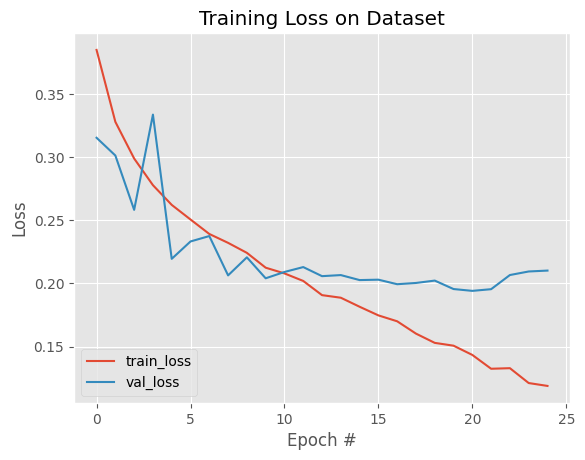

In [13]:
# plot the training loss
print(MODEL_PATH)
print(PLOT_PATH)

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(model, MODEL_PATH) # saves the model

### Prediction part

Here the trained model is loaded and use for prediction on test images.

In [33]:
# Load saved model for prediction

print(MODEL_PATH)

model = torch.load(MODEL_PATH) # add MODEL_PATH after training
print("model loaded for prediction")

model

/data/private/BPN_AI/mapAI-regularization/trained_models/dcswin-25-epochs-0510.pth
model loaded for prediction


DCSwin(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bi

#### Provide test images for MapAI Dataset

In [52]:
PREDICTIONS_DIR = os.path.join(GD_PATH, "predictions_fullimage_061023")
PREDICTIONS_DIR

'/data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023'

#### Make predictions on the entire MapAI dataset

Make predictions on test images and save them to the folder named predictions.

In [20]:
import random
import gc
from pathlib import Path
import numpy as np
from PIL import Image
import cv2

# PLOTTING PREDICTIONS AS SINGLE IMAGES

# Output folder for the predictions
output_folder = PREDICTIONS_DIR + "/" # check for Windows to save predictions inside the folder

# PLOT TEST IMAGES as RGB
for n in range(len(test_images)):
  gc.collect()
  # Test image number
  testImgName = str(Path(test_images[n]).stem) + '.tif'
  #print('#', testImgName)

   # Make predicton on a test image specified with counter n
  test_img = test_images[n]
  test_img_input = np.expand_dims(test_img, 0)
  #print('#', test_img_input[0])

  # PyTorch --> works
  model.eval()
  with torch.no_grad():
    image = cv2.imread(test_img_input[0])
    image = cv2.resize(image, dsize = (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255
    
    # print('SIZE: ', image.shape)

    # make the channel axis to be the leading one, add batch dimension
    image = np.transpose(image, (2, 0, 1))
    # create a PyTorch tensor
    image = np.expand_dims(image, 0)
    # flash the tensor to the device
    image  = torch.from_numpy(image).to(DEVICE)

    # make the prediction
    predMask = model(image).squeeze()
    # pass result through sigmoid
    predMask = torch.sigmoid(predMask)

    # convert result to numpy array
    predMask = predMask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    predMask = (predMask > THRESHOLD) * 255
    predMask = predMask.astype(np.uint8)

    # generate image from array
    pIMG = Image.fromarray(predMask)
    pIMG.save(str(output_folder + testImgName))

    #print('Prediction:', testImgName, 'saved to:', output_folder)

#### Make predictions on single images by choice

Change the parameter n to choose which image to plot.

In [53]:
output_folder = PREDICTIONS_DIR + "/" + "*.tif"

predictions = glob.glob(output_folder)
predictions.sort()
print("# IMAGES for prediction: ", len(predictions))

# IMAGES for prediction:  169


# IMAGES for prediction:  95


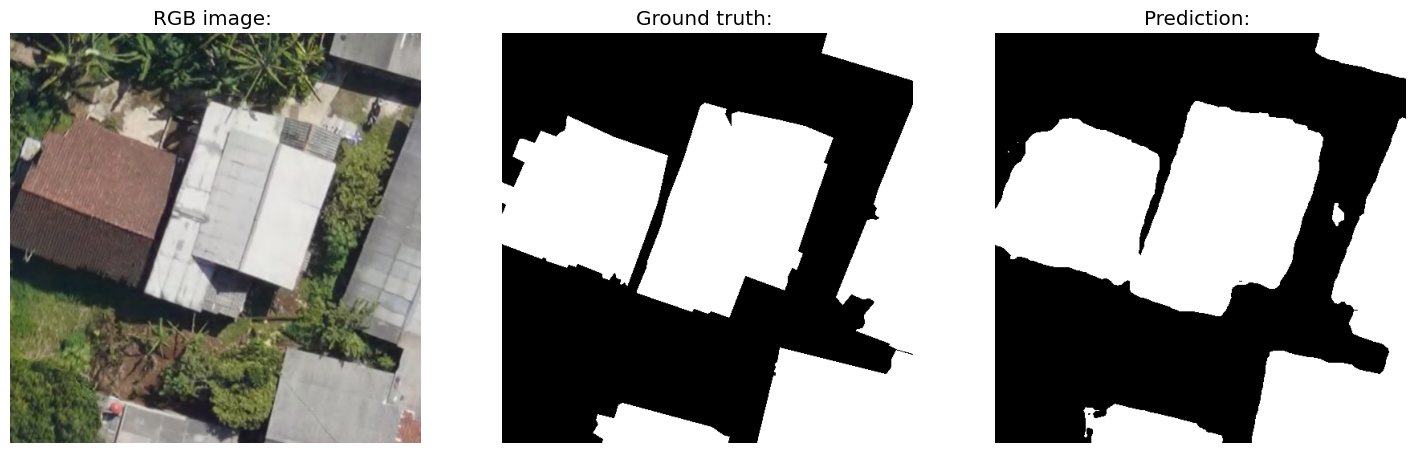

In [21]:
# ----------------------------------------------------------------------
import cv2

# print("Choosen n can be from 0 o 1367! ")


# ----------------------------------------------------------------------

n = 91 # change this number depending on which image you want to test

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(131)
ax1.set_title('RGB image: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(132)
ax2.set_title('Ground truth: ')
image = cv2.imread(test_masks[n])[:,:,::-1]
#image *= 255
ax2.imshow(image)
ax2.set_axis_off()

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

## Predict Full Image

In [34]:
#Tentukan lokasi direktori
FULL_IMG_DIR = os.path.join(GD_PATH, "data_full_img", "img1")
FULL_MASK_DIR = os.path.join(GD_PATH, "data_full_img", "mask")
FULL_IMG_TILES_DIR = os.path.join(GD_PATH, "data_full_img", "img1_tiles")

In [35]:
PREDICTIONS_FULL_DIR = os.path.join(GD_PATH, "predictions_fullimage_061023")
PREDICTIONS_FULL_DIR

'/data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023'

In [37]:
full_img_dir = os.path.join(FULL_IMG_DIR, "Kav_6_1.tif") #ganti sesuai nama file orthophoto 

patch_size = 1024

### Tilling

In [38]:
import cv2
import numpy as np
import patchify as p

def patchData(img, patch_dim:int, step_size:float):
    # pembulatan channel img
    ch1 = np.ceil(img.shape[0]/patch_dim).astype(int)
    ch2 = np.ceil(img.shape[1]/patch_dim).astype(int)

    # menambahkan kolom dan baris kosong pd gambar
    arr0 = np.zeros((ch1*patch_dim, ch2*patch_dim, 3))
    arr0[:img.shape[0], :img.shape[1]] += img
    arr = arr0.astype(np.uint8)

    # patch image
    patch_shape = (patch_dim, patch_dim, 3)
    patches = p.patchify(arr, patch_shape, step=int(patch_dim*step_size))

    img_patches = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            img_patches.append(patches[i,j,0,:,:,:])

    return np.array(img_patches)

In [39]:
img = cv2.imread(full_img_dir)

print(f'size ori : {img.shape}')

patch = patchData(img, patch_size, 1)
print(f'patch size : {patch.shape}')
print(patch.shape[0])

for i in range(patch.shape[0]):
    cv2.imwrite(FULL_IMG_TILES_DIR + f'/img_{i+1000}.png', patch[i])

size ori : (12957, 12649, 3)
patch size : (169, 1024, 1024, 3)
169


In [14]:
torch.cuda.empty_cache()

### Predicting full images

In [40]:
#Full Image

full_images = sorted(list(paths.list_images(FULL_IMG_TILES_DIR)))
#full_masks = sorted(list(paths.list_images(FULL_MASK_DIR)))

In [41]:
import random
import gc
from pathlib import Path
import numpy as np
from PIL import Image
import imagesize
import cv2

# PLOTTING PREDICTIONS AS SINGLE IMAGES

# Output folder for the predictions
output_folder_full = PREDICTIONS_FULL_DIR + "/" # check for Windows to save predictions inside the folder

# PLOT TEST IMAGES as RGB
for n in range(len(full_images)):
  gc.collect()
  # Test image number
  testImgName = str(Path(full_images[n]).stem) + '.tif'
  #IMG_WIDTH, IMG_HEIGHT = imagesize.get(testImgName)
    #print('#', testImgName)

   # Make predicton on a test image specified with counter n
  test_img = full_images[n]
  test_img_input = np.expand_dims(test_img, 0)
  #print('#', test_img_input[0])

  # PyTorch --> works
  model.eval()
  with torch.no_grad():
    image = cv2.imread(test_img_input[0])
    image = cv2.resize(image, dsize = (patch_size, patch_size), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255
    
    # print('SIZE: ', image.shape)

    # make the channel axis to be the leading one, add batch dimension
    image = np.transpose(image, (2, 0, 1))
    # create a PyTorch tensor
    image = np.expand_dims(image, 0)
    # flash the tensor to the device
    image  = torch.from_numpy(image).to(DEVICE)

    # make the prediction
    predMask = model(image).squeeze()
    # pass result through sigmoid
    predMask = torch.sigmoid(predMask)

    # convert result to numpy array
    predMask = predMask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    predMask = (predMask > THRESHOLD) * 255
    predMask = predMask.astype(np.uint8)

    # generate image from array
    pIMG = Image.fromarray(predMask)
    pIMG.save(str(output_folder_full + testImgName))

    print('Prediction:', testImgName, 'saved to:', output_folder_full)

Prediction: img_1000.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1001.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1002.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1003.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1004.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1005.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1006.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1007.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1008.tif saved to: /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/
Prediction: img_1009.tif saved to: /d

### Predict using Smooth Tiling

In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
#import segmentation_models as sm

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing

Segmentation Models: using `keras` framework.


In [9]:
full_img_dir = os.path.join(FULL_IMG_DIR, "bogor_images.tif")
full_mask_dir = os.path.join(FULL_MASK_DIR, "bogor_masks.tif")

img = cv2.imread(full_img_dir, 1)
#original_mask = cv2.imread(full_mask_dir, 1)
#original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)

In [11]:
import sys
subfolder = os.path.join(GD_PATH, "models")
sys.path.insert(0, subfolder)

import DCSwin_model

print(MODEL_PATH)

model = torch.load(MODEL_PATH) # add MODEL_PATH after training
print("model loaded for prediction")

/data/private/BPN_AI/mapAI-regularization/trained_models/dcswin-25-epochs.pth
model loaded for prediction


In [12]:
# size of patches
patch_size = 512

In [18]:
print(img.shape[1])
print(img.shape[0])

20696
11674


In [17]:
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
print(SIZE_X)
print(SIZE_Y)

20480
11264


In [19]:
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)     


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

DecompressionBombError: Image size (230686720 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

### BUILDING FOOTPRINT REGULARIZATION

Used repo: https://github.com/zorzi-s/projectRegularization

git clone the repo to the folder where your notebook is stored. To get curent working directory use os.getcwd().

The pretrained weights need to be downloaded from the provided link and saved into the folder pretrained_weighs that is inside projectRegularization:

https://drive.google.com/drive/folders/1IPrDpvFq9ODW7UtPAJR_T-gGzxDat_uu

Next step is to generate a Python file to locate the necessary pretrained weights from projectRegularization. The code below was only tested on Ubuntu, not on Windows.

In [56]:
# DEFINE NECESSARY PATHS FOR REGULARIZATION PART

projectRegDir = os.path.join(GD_PATH, "projectRegularization")
print(projectRegDir)

ptw = os.path.join(projectRegDir, "pretrained_weights") 
print(ptw)

# OUTPUT REGULARIZATIONS DIR
REGULARIZATION_DIR = os.path.join(GD_PATH, "regularizations_061023") + "/"
print(REGULARIZATION_DIR)

# GET THE PATHS FOR TRAINED GAN MODELS
ENCODER = os.path.join(ptw, "E140000_e1")
GENERATOR = os.path.join(ptw, "E140000_net")

print(ENCODER)
print(GENERATOR)

/data/private/BPN_AI/mapAI-regularization/projectRegularization
/data/private/BPN_AI/mapAI-regularization/projectRegularization/pretrained_weights
/data/private/BPN_AI/mapAI-regularization/regularizations_061023/
/data/private/BPN_AI/mapAI-regularization/projectRegularization/pretrained_weights/E140000_e1
/data/private/BPN_AI/mapAI-regularization/projectRegularization/pretrained_weights/E140000_net


In [49]:
# CREATE A NEW variables.py WITH USERS PATHS

with open(projectRegDir + 'variables.py', 'w') as f:
    f.write('# CONFIGURE THE PATHS HERE: \n\n')
    f.write('# TRAINING \n')
    f.write('DATASET_RGB = ' + '"' + str(TRAIN_IMG_DIR + '*.tif' + '"') + '\n')
    f.write('DATASET_GTI = ' + '"' + str(TRAIN_MASK_DIR + '*.tif' + '"') + '\n')
    f.write('DATASET_SEG = ' + '"' + str(PREDICTIONS_DIR + '*.tif' + '"') + '\n')
    f.write('\n')
    f.write('DEBUG_DIR = ' + '"' + str('./debug/') + '"' + '\n')
    f.write('\n')
    f.write('# INFERENCE \n')
    f.write('INF_RGB = ' + '"' + str(TEST_IMG_DIR + '*.tif' + '"') + '\n')
    f.write('INF_SEG = ' + '"' + str(PREDICTIONS_DIR + '*.tif' + '"') + '\n')
    f.write('INF_OUT = ' + '"' + str(REGULARIZATION_DIR + '"') + '\n')
    f.write('\n')
    f.write('MODEL_ENCODER = ' + '"' + str(ENCODER) + '"' + '\n')
    f.write('MODEL_GENERATOR = ' + '"' + str(GENERATOR) + '"' + '\n')
    f.close()
 
print("variables.py created with users paths...")


variables.py created with users paths...


#### Run projectRegularization

Takes around 6-8 minutes.

You only need to change the command below and replace it with the absolute path for regularize.py

In [43]:
!python /data/private/BPN_AI/mapAI-regularization/projectRegularization/regularize.py

/data/private/BPN_AI/mapAI-regularization/data_full_img/img1_tiles/img_1000.png /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/img_1000.tif
Regularization: 0it [00:00, ?it/s]
/data/private/BPN_AI/mapAI-regularization/projectRegularization/regularize.py:260: UserWarning: /data/private/BPN_AI/mapAI-regularization/regularizations_061023/img_1000.tif is a low contrast image
  io.imsave(output_file, np.uint8(R*255))
/data/private/BPN_AI/mapAI-regularization/data_full_img/img1_tiles/img_1001.png /data/private/BPN_AI/mapAI-regularization/predictions_fullimage_061023/img_1001.tif
Regularization: 0it [00:00, ?it/s]
/data/private/BPN_AI/mapAI-regularization/projectRegularization/regularize.py:260: UserWarning: /data/private/BPN_AI/mapAI-regularization/regularizations_061023/img_1001.tif is a low contrast image
  io.imsave(output_file, np.uint8(R*255))
/data/private/BPN_AI/mapAI-regularization/data_full_img/img1_tiles/img_1002.png /data/private/BPN_AI/mapAI-regularization/

### Compare predictions and regularizations on a single image

In [57]:
# Read Regularizations to plot and compare results

regularizations = glob.glob(REGULARIZATION_DIR + "*.tif")
regularizations.sort()

print("# of predicted images: ", len(predictions))
print("# of regularized images: ", len(regularizations))

# of predicted images:  169
# of regularized images:  169


Code to plot RGB, GT, PREDICTION and REGULARIZATION in a single plot for comparison.

Change parameter n accordingly.

In [ ]:
# PREDICTIONS_DIR = os.path.join(GD_PATH, "predictions_25ep")
# output_folder = PREDICTIONS_DIR + "/" + "*.tif"

# predictions = glob.glob(output_folder)
# predictions.sort()

/data/private/BPN_AI/mapAI-regularization/plots/compare-10.png


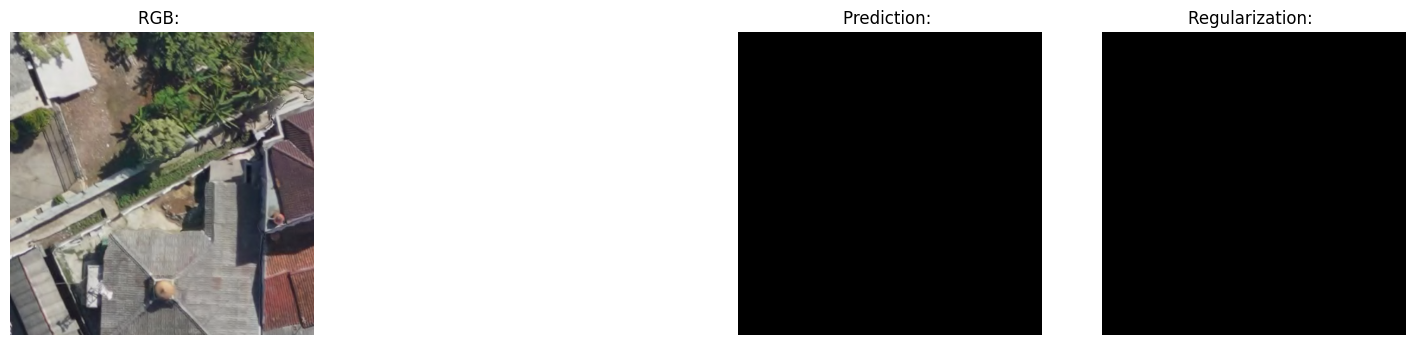

In [59]:
n = 10

fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(141)

ax1.set_title('RGB: ')
image = cv2.imread(test_images[n])[:,:,::-1]
ax1.imshow(image)
ax1.set_axis_off()

# ax2 = fig.add_subplot(142)
# ax2.set_title('Ground truth: ')
# image = cv2.imread(test_masks[n])[:,:,::-1]
# #image *= 255
# ax2.imshow(image)
# ax2.set_axis_off()

ax3 = fig.add_subplot(143)
ax3.set_title('Prediction: ')
image = cv2.imread(predictions[n])[:,:,::-1]
ax3.imshow(image)
ax3.set_axis_off()

ax4 = fig.add_subplot(144)
ax4.set_title('Regularization: ')
image = cv2.imread(regularizations[n])[:,:,::-1]
ax4.imshow(image)
ax4.set_axis_off()

# DEFINE PATH FOR PLOTS TO BE SAVED
figPath = GD_PATH + "/" + "plots" + "/" "compare-" + str(n) + ".png"
print(figPath)

# Save plot
fig.savefig(figPath)

### Combine patches into one full prediction image

In [9]:
full_images = sorted(list(paths.list_images(FULL_IMG_TILES_DIR)))
num_patches = len(full_images)

In [10]:
PREDICTIONS_FULL_DIR

'/data/private/BPN_AI/mapAI-regularization/predictions_fullimage_051023'

In [44]:
PREDICTIONS_REG_FULL_DIR = os.path.join(GD_PATH, "regularizations_051023")
PREDICTIONS_REG_FULL_DIR

'/data/private/BPN_AI/mapAI-regularization/regularizations_051023'

In [46]:
#Tentukan nama file hasil prediksi
full_pred_dir = "combined_kav61_image_061023.tif"

In [47]:
import cv2

original_image = cv2.imread(full_img_dir)

height_ori, width_ori, channels = original_image.shape

result_height = height_ori + (patch_size - (height_ori-(patch_size*int(height_ori/patch_size))))
result_width = width_ori + (patch_size - (width_ori-(patch_size*int(width_ori/patch_size))))

print(width_ori)
print(height_ori)
print(result_width)
print(result_height)

12649
12957
13312
13312


In [48]:
from PIL import Image

# # Define the folder containing the images in numerical order
# image_folder = "images/"

# # Define the dimensions of the resulting single image
# result_width = 20992  # Set your desired width
# result_height = 11776  # Set your desired height

# Create a blank result image with the specified dimensions
result_image = Image.new("I", (result_width, result_height))

# List the image files in the folder and sort them numerically
# image_files = [f"{image_folder}{i}.png" for i in range(1, len(os.listdir(image_folder)) + 1)]
# image_files.sort()
image_files = sorted(list(paths.list_images(PREDICTIONS_REG_FULL_DIR)))

# Initialize coordinates for pasting images in the result image
x, y = 0, 0

# Iterate through the image files and paste them into the result image
for image_file in image_files:
    image = Image.open(image_file)
    
    # Resize the image to fit within the specified dimensions
    image.thumbnail((result_width, result_height))
    
    # Paste the resized image into the result image at the current position
    result_image.paste(image, (x, y))
    
    # Update the x-coordinate for the next image
    x += image.width
    
    # If the x-coordinate exceeds the result_width, reset it and move to the next row
    if x >= result_width:
        x = 0
        y += image.height

#result_image = result_image.crop(0,0,width_ori,height_ori)

# Save the resulting single image
result_image.save(full_pred_dir)

#### Set Geotransform

In [26]:
from PIL import Image

# Open the PNG file
png_image = Image.open(full_pred_dir)
full_pred_dir = full_pred_dir.replace('.png', '.tif')

# Convert the PNG image to a TIFF image
# You can specify the output file format as 'TIFF' or 'TIF'
png_image.save(full_pred_dir, format='TIFF')

# Close the PNG image
png_image.close()


DecompressionBombError: Image size (247201792 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [49]:
from osgeo import gdal

# Open the source raster dataset
src_dataset = gdal.Open(full_img_dir, gdal.GA_ReadOnly)

# Get the geotransform from the source dataset
geotransform = src_dataset.GetGeoTransform()

# Close the source dataset
src_dataset = None

# Open a new or existing target raster dataset
# Replace 'target.tif' with the path to your target dataset
dst_dataset = gdal.Open(full_pred_dir, gdal.GA_Update)

# Set the geotransform for the target dataset
dst_dataset.SetGeoTransform(geotransform)

# Close the target dataset to save changes
dst_dataset = None

### VECTORIZING THE REGULARIZED BUILDING MASKS with GDAL

GDAL: https://gdal.org/'

GDAL: https://www.youtube.com/watch?v=q3DLdMj5zLA

I do not know if it is possible to install GDAL on WINDOWS inside a conda environment.

On Ubuntu you have to follow these steps:



Specific process for installation: https://stackoverflow.com/questions/44005694/no-module-named-gdal

- sudo apt-get update && sudo apt upgrade -y && sudo apt autoremove 
- sudo apt-get install -y cdo nco gdal-bin libgdal-dev-
- python -m pip install --upgrade pip setuptools wheel
- python -m pip install --upgrade gdal
- conda install -c conda forge libgdal
- conda install -c conda-forge libgdal
- conda install -c conda-forge gdal
- conda install tiledb=2.2
- conda install poppler

When you have this you can hopefully vectorize the detected masks quite easily.

In [30]:
def get_fname_from_path(path):
    """
    Given a path, returns the filename after the last frontslash character.
    """
    return path.rsplit('/', 1)[-1]

def get_fname_no_extension(path):
    """
    Given a path, returns the filename without its extension.
    """
    filename, extension = os.path.splitext(path)
    return filename

In [32]:
import osgeo
from osgeo import gdal
from osgeo import ogr
print('GDAL version: ', osgeo.gdal.__version__)

# Choose which image to vectorize
n  = 1

#input = Image.open('combined_image_051023a.tif')
input = regularizations[n]
print()
print("INPUT: ", input)

# print(get_fname_no_extension(input))

# out
output = get_fname_from_path(get_fname_no_extension(input)) + ".gpkg"
print("OUTPUT: ", output)

# Open image with GDAl driver
ds = gdal.Open(input)
# Get the band
band = ds.GetRasterBand(1)

# Create the output shapefile
driver = ogr.GetDriverByName("GPKG")
out_ds = driver.CreateDataSource(output)
out_layer = out_ds.CreateLayer(output, geom_type=ogr.wkbPolygon)

# Add a field to the layer to store the pixel values
field_defn = ogr.FieldDefn("Pix_Value", ogr.OFTInteger)
out_layer.CreateField(field_defn)

# Polygonize the PNG file
gdal.Polygonize(band, None, out_layer, 0, [], callback=None)

# Close the input and output files
out_ds = None
ds = None

GDAL version:  3.5.0


DecompressionBombError: Image size (247201792 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

For the builing detection case we need to only keep the vectors with pixel value 255. Easiest solution is to use: Extract by attribute. The Python solution with GDAL can be found below.

In [ ]:
# ogr2ogr -where ID="1" outfile.gpkg infile.

# RUN from the command line inside Ubuntu
!ogr2ogr -where Pix_Value="255" bergen_-5943_1104B.gpkg bergen_-5943_1104.gpkg